In [1]:
source("TimeSeriesSimilarity.r") # used for similarity matrix
library("WGCNA")

Warning message:
"package 'proxy' was built under R version 3.6.1"
Attaching package: 'proxy'

The following objects are masked from 'package:stats':

    as.dist, dist

The following object is masked from 'package:base':

    as.matrix

Warning message:
"package 'dtw' was built under R version 3.6.1"Loaded dtw v1.20-1. See ?dtw for help, citation("dtw") for use in publication.

Warning message:
"package 'rucrdtw' was built under R version 3.6.1"Warning message:
"package 'WGCNA' was built under R version 3.6.1"Loading required package: dynamicTreeCut
Loading required package: fastcluster

Attaching package: 'fastcluster'

The following object is masked from 'package:stats':

    hclust


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'WGCNA'

The following object is masked from 'package:stats':

    cor



The main function here is WGCNA_TS which return module membership. That is a p-vector whose coordinate corresponds to the module index that feature belong to.
The parameters details (which can be used for test WGCNA_TS function) and the actual functions are in the section "Function" and a step by step procedures (helps visualize and choose parameters more closely) are in the section "step by step"

# Functions

In [3]:
WGCNA_TS = function(X,len_time,softPower=6,minModuleSize=30,MEDissThres=0.25,
                   type = "cor"){
    # similairity matrix (in terms of time series)
    sim_mat = similarity_TS(X,len_time = len_time,type = type) # time series measure
    # adjacency matrix
    adjacency_mat = sim_mat^softPower
    # TOM
    TOM = TOMsimilarity(adjacency_mat)
    # distance matrix
    dissTOM = 1-TOM
    #cluster using dissTom
    geneTree = hclust(as.dist(dissTOM), method = "average")
    # Module identification using dynamic tree cut (cut the genetree)
    dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM,deepSplit = 2, 
                                pamRespectsDendro = FALSE,minClusterSize = minModuleSize)

    # merge similar modules
    if (length(table(dynamicMods))==1){
        names(dynamicMods) = names(X)
        return (dynamicMods)
    }

    # Calculate eigengenes
    # colors is the current module membership
    MEList = moduleEigengenes(X, colors = dynamicMods)  
    MEs = MEList$eigengenes
    # Calculate dissimilarity of module eigengenes
    MEDiss = 1-cor(MEs)
    # Cluster module eigengenes
    METree = hclust(as.dist(MEDiss), method = "average")
    # We choose a height cut of MEDissThres (= 0.25 for example) corresponding to 
    # correlation of 1-MEDissThres (0.75) to merge
    # Call an automatic merging function; dynamicMods is the membership before merge
    merge = mergeCloseModules(X, dynamicMods, cutHeight = MEDissThres, 
                              verbose = 3)
    moduleColors = merge$colors
    names(moduleColors) = names(X)
    return (moduleColors)
}

In [4]:
# Only for test, regular WGCNA using correlation
WGCNA_regular = function(X,len_time,softPower=6,minModuleSize=30,MEDissThres=0.25){
    # similairity matrix 
    sim_mat = abs(cor(X)) # wgcna's naive way
    # adjacency matrix
    adjacency_mat = sim_mat^softPower
    # TOM
    TOM = TOMsimilarity(adjacency_mat)
    # distance matrix
    dissTOM = 1-TOM
    #cluster using dissTom
    geneTree = hclust(as.dist(dissTOM), method = "average")
    # Module identification using dynamic tree cut (cut the genetree)
    dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM,deepSplit = 2, 
                                pamRespectsDendro = FALSE,minClusterSize = minModuleSize)

    # merge similar modules
    if (length(table(dynamicMods))==1){
        names(dynamicMods) = names(X)
        return (dynamicMods)
    }

    # Calculate eigengenes
    # colors is the current module membership
    MEList = moduleEigengenes(X, colors = dynamicMods)  
    MEs = MEList$eigengenes
    # Calculate dissimilarity of module eigengenes
    MEDiss = 1-cor(MEs)
    # Cluster module eigengenes
    METree = hclust(as.dist(MEDiss), method = "average")
    # We choose a height cut of MEDissThres (= 0.25 for example) corresponding to 
    # correlation of 1-MEDissThres (0.75) to merge
    # Call an automatic merging function; dynamicMods is the membership before merge
    merge = mergeCloseModules(X, dynamicMods, cutHeight = MEDissThres, 
                              verbose = 3)
    moduleColors = merge$colors
    names(moduleColors) = names(X)
    return (moduleColors)
}

# Step by step

Note:The only difference with regular WGCNA is the following


Time series WGCNA:


sim_mat = similarity_TS(X,len_time = len_time,type = "L2")


Regular WGCNA:


sim_mat = abs(cor(X, use = "p"))


To compare the two, you can comment one of them to run all of the following code.

## Calculate similarity, adjacency, TOM and dissTom and cluster

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


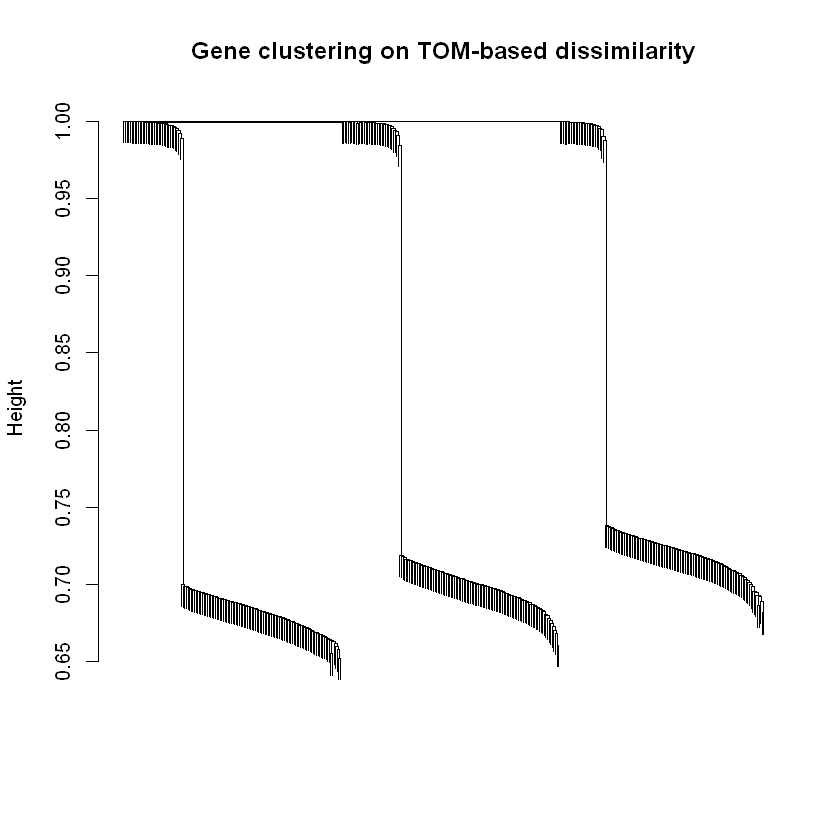

In [96]:
#data
data <- read.csv(file="data4.csv", header=TRUE, sep=",")
data = data[,-1] # delete the X column (name of rows)
X = data[,-ncol(data)]
y = data[,ncol(data)]

# the time length for each units
len_time = rep(5,100)
# beta
softPower = 4

###################Important lines##################

# similairity matrix (in terms of time series)
# you can comment one of the following two to compare time series WGCNA and regular one
sim_mat = similarity_TS(X,len_time = len_time,type = "cor") # time series measure
# sim_mat = abs(cor(X, use = "p")) # regular WGCNA

###################End Important Lines################


# adjacency matrix
adjacency_mat = sim_mat^softPower
# TOM
TOM = TOMsimilarity(adjacency_mat)
# distance matrix
dissTOM = 1-TOM
#cluster using dissTom
geneTree = hclust(as.dist(dissTOM), method = "average")
#plot the geneTree
plot(geneTree, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",
     labels = FALSE, hang = 0.04)

## Tree cut to make modules

In [97]:
# We like large modules, so we set the minimum module size relatively high
minModuleSize = 30
# Module identification using dynamic tree cut (cut the genetree)
# dynamicMods is module membership
dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM,deepSplit = 2, 
                            pamRespectsDendro = FALSE,minClusterSize = minModuleSize)
names(dynamicMods) = names(X)
table(dynamicMods)
dynamicMods

 ..cutHeight not given, setting it to 0.997  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods
  0   1   2   3 
 85 106 105 104 

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  V95  V96 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
 V97  V98  V99 V100 V101 V102 V103 V104 V105 V106 V107 V108 V109 V110 V111 V112 
   1    1    1    1    2    2    2    2    2    2    2    2    2    2    2    2 
V113 V114 V115 V116 V117 V118 V119 V120 V121 V122 V123 V124 V125 V126 V127 V128 
   2    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2 
V129 V130 V131 V132 V133 V134 V135 V136 V137 V138 V139 V140 V141 V142 V143 V144 
   2    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2 
V145 V146 V147 V148 V149 V150 V151 V152 V153 V154 V155 V156 V157 V158 V159 V160 
   2    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2 
V161 V162 V163 V164 V165 V166 V167 V168 V169 V170 V171 V172 V173 V174 V175 V176 
   2    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2 
V177 V178 V179 V180 V181 V182 V183 V184 V185 V186 V187 V188 V189 V190 V191 V192 
   2    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2 
V193 V194 V195 V196 V197 V198 V199 V200 V201 V202 V203 V204 V205 V206 V207 V208 
   2    2    2    2    2    2    2    2    3    3    3    3    3    3    3    3 
V209 V210 V211 V212 V213 V214 V215 V216 V217 V218 V219 V220 V221 V222 V223 V224 
   3    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3 
V225 V226 V227 V228 V229 V230 V231 V232 V233 V234 V235 V236 V237 V238 V239 V240 
   3    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3 
V241 V242 V243 V244 V245 V246 V247 V248 V249 V250 V251 V252 V253 V254 V255 V256 
   3    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3 
V257 V258 V259 V260 V261 V262 V263 V264 V265 V266 V267 V268 V269 V270 V271 V272 
   3    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3 
V273 V274 V275 V276 V277 V278 V279 V280 V281 V282 V283 V284 V285 V286 V287 V288 
   3    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3 
V289 V290 V291 V292 V293 V294 V295 V296 V297 V298 V299 V300 V301 V302 V303 V304 
   3    3    3    3    3    3    3    3    3    3    3    3    1    0    0    0 
V305 V306 V307 V308 V309 V310 V311 V312 V313 V314 V315 V316 V317 V318 V319 V320 
   0    0    0    1    0    0    3    0    0    1    0    0    0    0    0    0 
V321 V322 V323 V324 V325 V326 V327 V328 V329 V330 V331 V332 V333 V334 V335 V336 
   0    0    0    0    1    0    3    0    0    0    0    0    0    0    2    0 
V337 V338 V339 V340 V341 V342 V343 V344 V345 V346 V347 V348 V349 V350 V351 V352 
   0    0    0    0    0    2    2    0    0    0    0    0    0    0    0    0 
V353 V354 V355 V356 V357 V358 V359 V360 V361 V362 V363 V364 V365 V366 V367 V368 
   0    0    0    0    2    0    0    0    0    0    0    1    0    0    0    2 
V369 V370 V371 V372 V373 V374 V375 V376 V377 V378 V379 V380 V381 V382 V383 V384 
   0    0    0    0    0    0    0    0    1    0    0    0    0    0    0    3 
V385 V386 V387 V388 V389 V390 V391 V392 V393 V394 V395 V396 V397 V398 V399 V400 
   0    0    0    0    0    0    

## Plot the original geneTree and the result (color) of tree cut

dynamicColors
     blue     brown      grey turquoise 
      105       104        85       106 

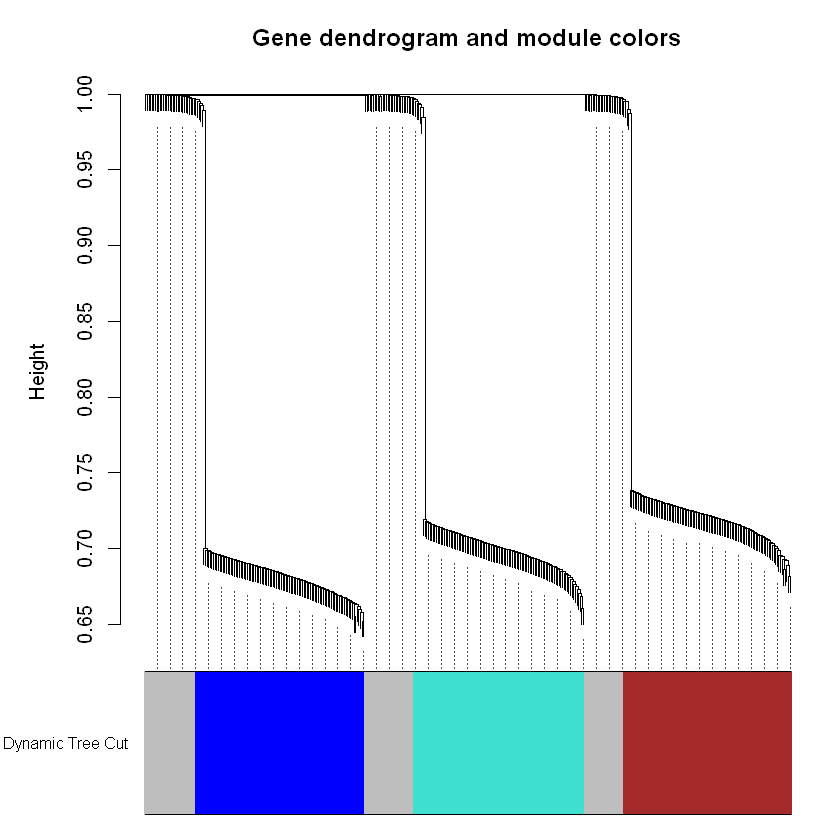

In [98]:
# Convert numeric lables into colors
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)
# Plot the dendrogram and colors underneath
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,addGuide = TRUE, 
                    guideHang = 0.05,main = "Gene dendrogram and module colors")

## Merging of modules whose expression profiles are very similar

Note: the data here is not good since we do not need this step here. But in general we need this merging step by computing eigengenes.

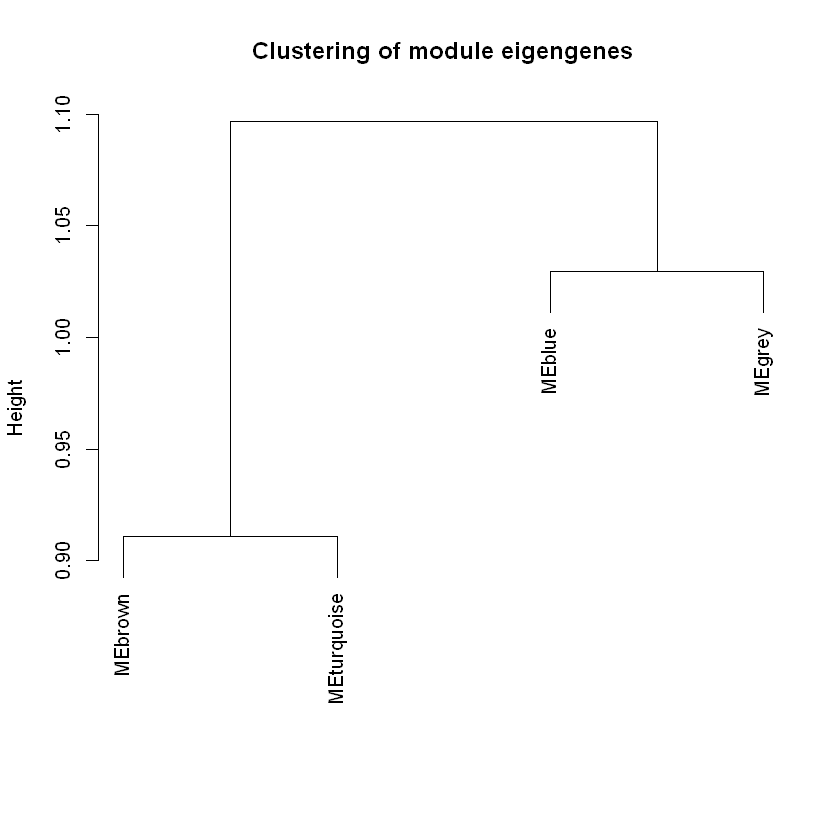

In [99]:
# Calculate eigengenes
# colors is the current module membership
MEList = moduleEigengenes(X, colors = dynamicColors)  
MEs = MEList$eigengenes
# Calculate dissimilarity of module eigengenes
MEDiss = 1-cor(MEs)
# Cluster module eigengenes
METree = hclust(as.dist(MEDiss), method = "average")
#  Plot the result
plot(METree, main = "Clustering of module eigengenes",xlab = "", sub = "")

 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 4 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 4 module eigengenes in given set.


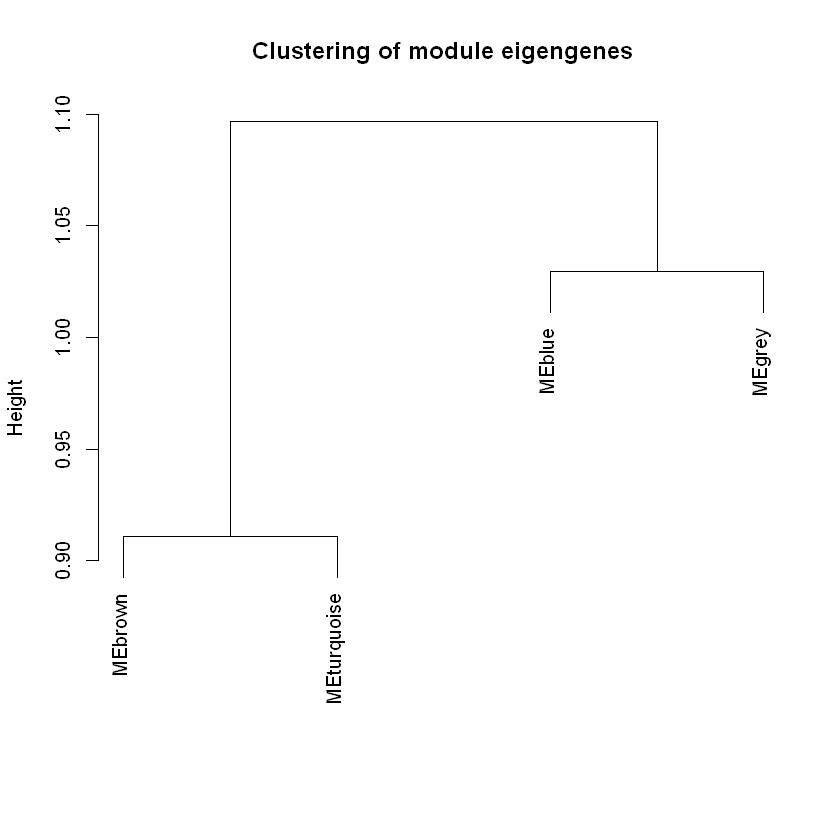

In [100]:
# We choose a height cut of 0.25, corresponding to correlation of 0.75, to merge
MEDissThres = 0.25
plot(METree, main = "Clustering of module eigengenes",xlab = "", sub = "")
abline(h=MEDissThres, col = "red")
# Call an automatic merging function
merge = mergeCloseModules(X, dynamicColors, cutHeight = MEDissThres, 
                          verbose = 3)
# The merged module colors
mergedColors = merge$colors # module membership
# Eigengenes of the new merged modules
mergedMEs = merge$newMEs

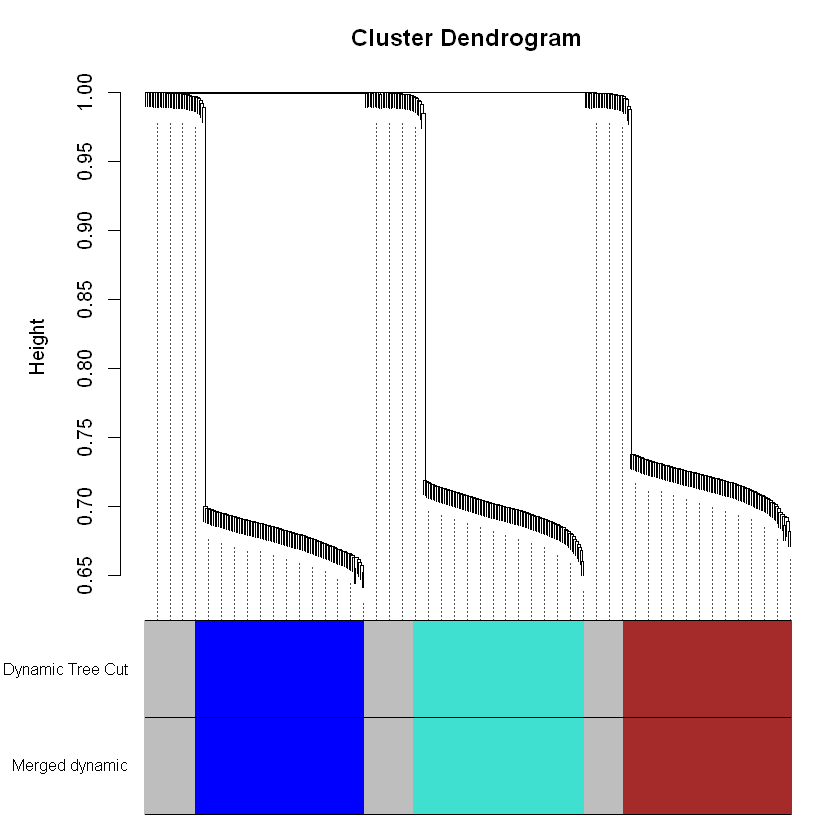

In [101]:
plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    dendroLabels = FALSE, hang = 0.03,addGuide = TRUE, 
                    guideHang = 0.05)

In [103]:
# Now the moduleColors should be the mergedColors
moduleColors = mergedColors # final module membership